In [ ]:
!pip install pycocotools


In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-07-25 05:03:41--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.231.33, 52.217.228.1, 3.5.7.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.231.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  17.3MB/s    in 47s     

2024-07-25 05:04:28 (16.5 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2024-07-25 05:04:28--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.113.187, 16.182.64.121, 52.217.98.20, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.113.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 1

In [ ]:
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

In [ ]:
dataDir = '/content'
dataType = 'val2017'
annFile = f'{dataDir}/annotations/person_keypoints_{dataType}.json'
imageDir = f'{dataDir}/{dataType}'
outputDir = '/content/images'

In [ ]:
import os
import shutil
import json
from pycocotools.coco import COCO
if not os.path.exists(outputDir):
    os.makedirs(outputDir)


In [ ]:
coco = COCO(annFile)

catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

keypoints_data = []

for imgId in imgIds:
    annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    if len(anns) == 1 and anns[0]['num_keypoints'] == 17 and all(kp > 0 for kp in anns[0]['keypoints'][2::3]):
        img = coco.loadImgs(imgId)[0]
        src = os.path.join(imageDir, img['file_name'])
        dst = os.path.join(outputDir, img['file_name'])
        shutil.copy(src, dst)

        keypoints_data.append({
            'file_name': img['file_name'],
            'keypoints': anns[0]['keypoints'],
            'bbox': anns[0]['bbox']
        })

json_path = '/content/keypoints_data.json'
with open(json_path, 'w') as f:
    json.dump(keypoints_data, f, indent=4)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [ ]:
## make directories for input to videopose3d
!mkdir -p /content/inputs

In [ ]:
import os
import subprocess
from tqdm import tqdm

input_dir = '/content/images'
output_dir = '/content/inputs'

for image_file_name in tqdm(os.listdir(input_dir)):
    if image_file_name.endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(input_dir, image_file_name)
        name = image_file_name.split('.')[0]
        resized_name = f'{name}_resized.jpg'
        video_name = f'{name}.mp4'
        resized_path = os.path.join(output_dir, resized_name)
        video_path = os.path.join(output_dir, video_name)


        subprocess.run([
            'ffmpeg', '-i', src,
            '-vf', 'scale=trunc(iw/2)*2:trunc(ih/2)*2',
            resized_path
        ], check=True)

        subprocess.run([
            'ffmpeg', '-loop', '1', '-framerate', '1',
            '-i', resized_path,
            '-c:v', 'libx264', '-t', '1', '-pix_fmt', 'yuv420p',
            '-r', '1',
            video_path
        ], check=True)


        os.remove(resized_path)

print("All videos have been saved.")


100%|██████████| 82/82 [00:32<00:00,  2.49it/s]

All videos have been saved.


In [ ]:
## import all neccesary things and set up to do pose estimation with video pose 3d
!git clone https://github.com/facebookresearch/VideoPose3D

Cloning into 'VideoPose3D'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 9.53 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
cd VideoPose3D

/content/VideoPose3D


In [ ]:
mkdir checkpoint

In [ ]:
cd checkpoint

/content/VideoPose3D/checkpoint


In [ ]:
!wget https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin

--2024-07-25 05:08:39--  https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67892577 (65M) [application/octet-stream]
Saving to: ‘pretrained_h36m_detectron_coco.bin’

pretrained_h36m_det 100%[===================>]  64.75M   277MB/s    in 0.2s    

2024-07-25 05:08:39 (277 MB/s) - ‘pretrained_h36m_detectron_coco.bin’ saved [67892577/67892577]



In [ ]:
cd /content

/content


In [ ]:
mkdir output

In [ ]:
mkdir results

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-uel31tpl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-uel31tpl
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
cd /content/VideoPose3D/inference

/content/VideoPose3D/inference


##Replace infer_video_d2.py with same script in video_pose_3d(videos).ipynb in same repository before running the code below

In [ ]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir /content/output/ \
    --image-ext mp4 \
    /content/inputs

[07/25 05:14:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl ...
model_final_997cc7.pkl: 313MB [00:01, 236MB/s]               
Processing /content/inputs/000000273760.mp4
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enabl

In [ ]:
cd /content/VideoPose3D/data

/content/VideoPose3D/data


In [ ]:
!python prepare_data_2d_custom.py -i /content/output -o myvideos


Parsing 2D detections from /content/output
Processing /content/output/000000054931.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000250127.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000460333.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000412286.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000102356.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000352760.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000161875.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000274411.mp4.npz
1 total frames processed
0 frames were interpolated
----------
Processing /content/output/000000023359.mp4.npz
1 total frames proces

In [ ]:
cd /content/VideoPose3D

/content/VideoPose3D


In [ ]:
import os
import subprocess

# Directory setup
input_dir = '/content/inputs'
intermediate_dir = '/content/intermediate'
results_dir = '/content/results'
video_pose3d_dir = '/content/VideoPose3D'

# Ensure necessary directories exist
os.makedirs(intermediate_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
from tqdm import tqdm
for video_name in tqdm(os.listdir(input_dir)):
    if video_name.endswith('.mp4'):
        name = video_name.split('.')[0]
        processed_vid_name = f'{name}_processed.mp4'
        final_image_name = f'{name}_final.jpg'

        subprocess.run([
            'python', 'run.py', '-d', 'custom', '-k', 'myvideos', '-arc', '3,3,3,3,3', '-c', 'checkpoint',
            '--evaluate', 'pretrained_h36m_detectron_coco.bin', '--render',
            '--viz-subject', video_name, '--viz-action', 'custom', '--viz-camera', '0',
            '--viz-video', os.path.join(input_dir, video_name),
            '--viz-output', os.path.join(intermediate_dir, processed_vid_name),
            '--viz-size', '6'
        ], cwd=video_pose3d_dir)

        # Extract the first frame from the output video and save to results
        subprocess.run([
            'ffmpeg', '-i', os.path.join(intermediate_dir, processed_vid_name),
            '-vf', 'select=eq(n\,0)', '-q:v', '3', os.path.join(results_dir, final_image_name)
        ])

100%|██████████| 82/82 [05:33<00:00,  4.07s/it]


In [ ]:
import numpy as np
data = np.load(os.path.join(video_pose3d_dir, 'data/data_2d_custom_myvideos.npz'), allow_pickle=True)
pred_keypoints = data['positions_2d'].item()


In [ ]:
import os
import json
import numpy as np

def load_keypoints(keypoints_file):
    with open(keypoints_file, 'r') as file:
        data = json.load(file)
    keypoints_dict = {}
    for item in data:
        image_name = item['file_name'].split('.')[0] + '.mp4'
        keypoints = np.array(item['keypoints']).reshape(-1, 3)[:, :2]
        bbox = item['bbox']
        keypoints_dict[image_name] = {'keypoints': keypoints, 'bbox': bbox}
    return keypoints_dict

In [ ]:
def compute_keypoint_distances(predicted_keypoints, ground_truth_keypoints):
    distances = np.sqrt(np.sum((predicted_keypoints - ground_truth_keypoints)**2, axis=1))
    return distances

In [ ]:
keypoints_file = '/content/keypoints_data.json'
ground_truth_keypoints_bbox = load_keypoints(keypoints_file)

In [ ]:
keypoint_distances = {i: [] for i in range(17)}


In [ ]:
predicted_data = pred_keypoints
for video_name, data in predicted_data.items():
    if video_name in ground_truth_keypoints_bbox:
        predicted_kps = np.array(data['custom'][0][0])[:, :2]
        ground_truth_kps = np.array(ground_truth_keypoints_bbox[video_name]['keypoints'])[:, :2]

        distances = compute_keypoint_distances(predicted_kps, ground_truth_kps)


        for idx, dist in enumerate(distances):
            keypoint_distances[idx].append(dist)
    else:
        print(f"Ground truth data missing for {video_name}")

In [ ]:
average_distances = {k: np.mean(v) if v else None for k, v in keypoint_distances.items()}

In [ ]:
for keypoint_idx, avg_dist in average_distances.items():
    print(f"Average distance for keypoint {keypoint_idx}: {avg_dist:.2f}")

Average distance for keypoint 0: 4.36
Average distance for keypoint 1: 4.24
Average distance for keypoint 2: 3.97
Average distance for keypoint 3: 4.54
Average distance for keypoint 4: 5.17
Average distance for keypoint 5: 6.71
Average distance for keypoint 6: 7.04
Average distance for keypoint 7: 7.44
Average distance for keypoint 8: 6.51
Average distance for keypoint 9: 7.35
Average distance for keypoint 10: 8.80
Average distance for keypoint 11: 10.93
Average distance for keypoint 12: 9.86
Average distance for keypoint 13: 8.53
Average distance for keypoint 14: 10.56
Average distance for keypoint 15: 10.85
Average distance for keypoint 16: 13.87


In [ ]:
mean_distances = []
for keypoint_idx, avg_dist in average_distances.items():
    mean_distances.append(avg_dist)
mean_distances = np.array(mean_distances)

### Plotting the circles on image


In [ ]:
#list of images
images_list = os.listdir('/content/inputs')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_keypoints_on_image(image_name, average_distances):
    str1 = image_name.split('.')[0]
    image_path = f'/content/images/{str1}.jpg'
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ground_truth_kps, predicted_kps, bbox = get_keypoints(image_name)

    distances = np.sqrt(np.sum((ground_truth_kps - predicted_kps) ** 2, axis=1))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    # Draw each keypoint
    for i, (gt, dist) in enumerate(zip(ground_truth_kps, distances)):
        circle_color = 'green' if dist <= average_distances[i] else 'red'
        ax.plot(gt[0], gt[1], 'bo')
        min_radius = 5
        actual_radius = max(min_radius, dist)
        circle = plt.Circle((gt[0], gt[1]), radius=actual_radius, color=circle_color, fill=False, linewidth=2.5)
        ax.add_patch(circle)

    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.axis('off')
    plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_stickman_on_canvas(image_name, average_distances):
    str1 = image_name.split('.')[0]
    image_path = f'/content/images/{str1}.jpg'
    print(image_path)
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([0, width])
    ax.set_ylim([height, 0])

    ground_truth_kps, predicted_kps, bbox = get_keypoints(image_name)
    distances = np.sqrt(np.sum((ground_truth_kps - predicted_kps) ** 2, axis=1))


    connections = [
        (0, 1), (1, 3), (0, 2), (2, 4),
        (1, 5), (2, 6),
        (5,6),
        (5, 7), (7, 9),
        (6, 8), (8, 10),
        (5, 11), (6, 12), (11, 12),
        (11, 13), (13, 15),
        (12, 14), (14, 16)
    ]



    for start, end in connections:
        if start < len(ground_truth_kps) and end < len(ground_truth_kps):  # Check if keypoints exist
            ax.plot([ground_truth_kps[start][0], ground_truth_kps[end][0]],
                    [ground_truth_kps[start][1], ground_truth_kps[end][1]], 'r-')


    for i, (gt, dist) in enumerate(zip(ground_truth_kps, distances)):
        circle_color = 'green' if dist <= average_distances[i] else 'red'
        ax.plot(gt[0], gt[1], 'bo')
        min_radius = 5
        actual_radius = max(min_radius, dist)
        circle = plt.Circle((gt[0], gt[1]), radius=actual_radius, color=circle_color, fill=False, linewidth=2.5)
        ax.add_patch(circle)


    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

    plt.axis('off')
    plt.show()

In [ ]:
#choose a random image to plot
import random
random_image = random.choice(images_list)

/content/images/000000326128.jpg


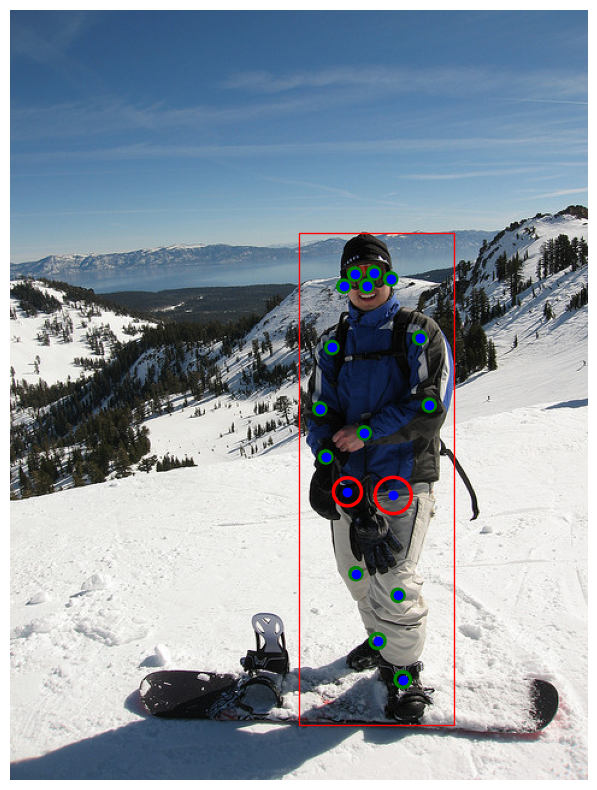

/content/images/000000326128.jpg


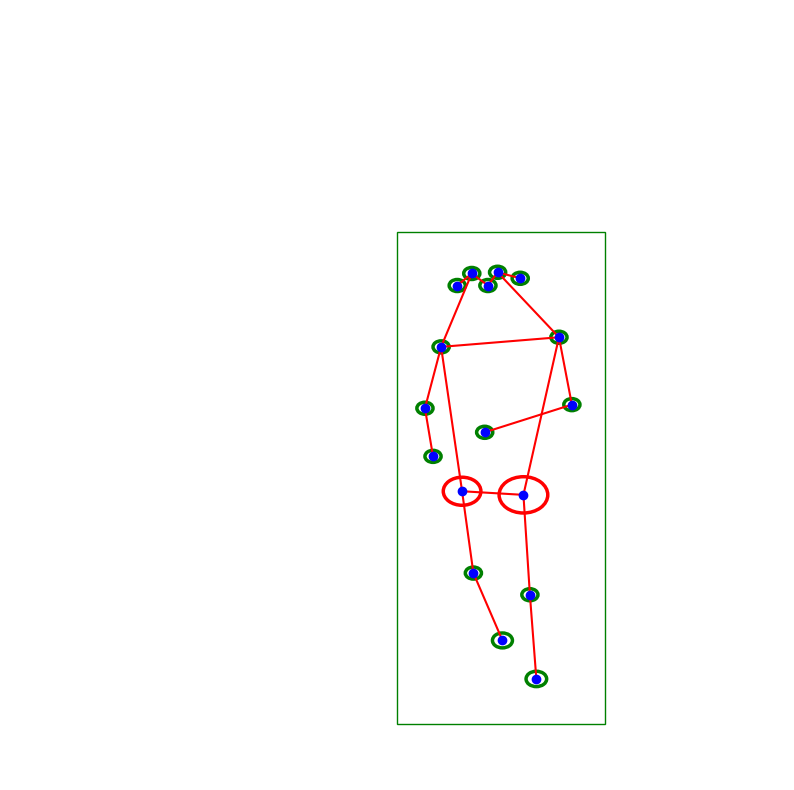

In [ ]:
image_name = random_image
def get_keypoints(image_file_name):
  truth = ground_truth_keypoints_bbox[image_name]['keypoints']
  pred = predicted_data[image_name]['custom'][0][0]
  bbox = ground_truth_keypoints_bbox[image_name]['bbox']
  return truth, pred, bbox

plot_keypoints_on_image(image_name, mean_distances)
plot_stickman_on_canvas(image_name, mean_distances)